In [1]:
%%capture
import numpy as np
!pip install qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

# Distribuciones de probabilidad clásicas


Vamos a comparar sistemas clásicos y cuánticos.

Tiremos una moneda. Podemos asociarla a una variable aleatoria $X$ que toma el valor 0 si sale cara o 1 si sale ceca. Obtenemos cara con probabilidad $P(X=0) = p_0$ y ceca con $P(X=1) = p_1$ para cada una de las monedas. En teoría clásica, $p_i\geq 0$ para todo $i$, y las probabilidades suman 1: $\sum_i p_i = 1$. 

In [2]:
#Simulemos 100 tiradas de monedas cargadas
import numpy as np
n_samples = 100
p_1 = 0.2
x_data = np.random.binomial(1, p_1, (n_samples,))
print(x_data)

[0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0]


Cheueemos que las frecuencias obtenidas empíricamente suman 1:




In [3]:
frequency_of_zeros, frequency_of_ones = 0, 0
for x in x_data:
    if x:
        frequency_of_ones += 1/n_samples
    else:
        frequency_of_zeros += 1/n_samples
print(frequency_of_ones+frequency_of_zeros)

1.0000000000000004


Como $p_0$ y $p_1$ deben ser no negativas, las posibles distribuciones de probabilidad están restringidas al cuadrante positivo. Debido a la condición de normalización, las posibles distribuciones de probabilidades viven en una linea recta.

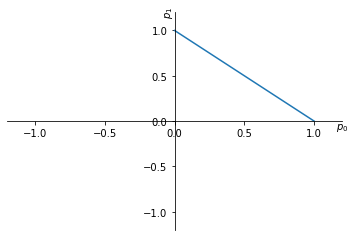

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
p_0 = np.linspace(0, 1, 100)
p_1 = 1-p_0
fig, ax = plt.subplots()
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel("$p_0$")
ax.xaxis.set_label_coords(1.0, 0.5)
ax.set_ylabel("$p_1$")
ax.yaxis.set_label_coords(0.5, 1.0)
plt.plot(p_0, p_1)

Una forma más elegante de describir las probabilidades consiste en usar notación vectorial, donde  $\vec{p} = \begin{bmatrix} p_0 \\ p_1 \end{bmatrix}$. 
Un vector que representa una distribución de probabilidad se conoce como *vector estocástico*. La condición de normalización le impone a este vector tener norma 1 igual a 1 ($||\vec{p}||_1 = \sum_i |p_i| = 1$). 

In [5]:
p = np.array([[0.8], [0.2]])
np.linalg.norm(p, ord=1)

1.0

In [6]:
sum(p)[0]

1.0

In [7]:
np.linalg.norm(p, 1)

1.0

In [8]:
if p.all()>0 and sum(p)[0]==1:
  print("test")

test


In [9]:
round(p[1][0],0)

0.0

Sabemos que el primer elemento del vector $\vec{p}$ corresponde a la probabilidad de obtener cara, pero al tratarse de un vector podemos extraerlo directamente usando álgebra lineal. Geometricamente, corresponde a proyectar el vector sobre el primer eje. Esta proyección se describe con la matriz  $\begin{bmatrix} 1 & 0\\0 & 0\end{bmatrix}$. La norma 1 del vector resultante se corresponde con la probabilidad:

In [10]:
Π_0 = np.array([[1, 0], [0, 0]])
np.linalg.norm(Π_0 @ p, ord=1)

0.8

Podemos hacer lo mismo con las probabilidades de obtener ceca.

In [11]:
Π_1 = np.array([[0, 0], [0, 1]])
np.linalg.norm(Π_1 @ p, ord=1)

0.2

Si quisiesemos transformar las probabilidades, tendríamos que multiplicar estos vectores por matrices con ciertas condiciones. Estas matrices se conocen como *matrices estocásticas* y mapean vectores estocásticos en vectores estocásticos. Puede ser izquierda o derecha dependiendo de que lado querramos multiplicar (izquierda es tal que sus columnas suman 1, y derecha es tal que sus filas suman a 1). Veamos un ejemplo.

In [12]:
p = np.array([[.5], [.5]])
M = np.array([[0.7, 0.6], [0.3, 0.4]])
np.linalg.norm(M @ p, ord=1)

0.9999999999999999

Un último concepto de suma utilidad es el de entropía. Una distribución de probabilidad tiene entropía definida como $H(p) = - \sum_i p_i \log_2 p_i$. 
Basicamente mide el grado de desconocimiento que tenemos sobre el sistema. Grafiquemosla sobre todas las pobiles distribuciones de probabilidad para la moneda:

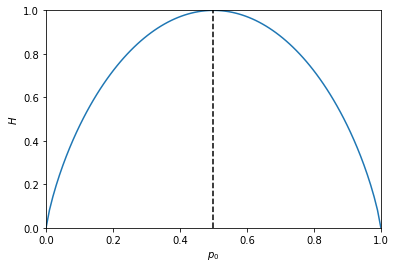

In [13]:
ϵ = 10e-10
p_0 = np.linspace(ϵ, 1-ϵ, 100)
p_1 = 1-p_0
H = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, -np.log2(0.5))
ax.set_xlabel("$p_0$")
ax.set_ylabel("$H$")
plt.plot(p_0, H)
plt.axvline(x=0.5, color='k', linestyle='--')

Es máxima para la moneda uniforma. En general, la entropía se hace máxima para distribuciones homogeneas. Es la distribución menos predecible. La entropía cuantifica el grado de sorpresa y inpredicibilidad.

# Estados cuánticos



Una moneda clásica es un sistema de dos niveles: es cara ó ceca. El [estado cuántico](https://en.wikipedia.org/wiki/Quantum_state) más simple es también de dos niveles, y lo llamamos qubit. De la misma forma que escribimos una distribución de probabilidad como un vector columna, podemos escribir un estado cuántico como un vector columna. Por cuestiones de notación, los estados cuánticos suelen escribirse con notación de Dirac (kets y bras). Por ejemplo, escribimos el ket de un qubit como

$$
|\psi\rangle = \begin{bmatrix}
    a_0 \\
    a_1 \\
\end{bmatrix}.
$$

Un ket es un vector columna. En lugar de indicarlo con una flecha sobre el nombre, lo ponemos en esta notación. La gran diferencia es la normalización, que ahora depende de la norma 2:

$$
\sqrt{|a_0|^2+|a_1|^2}=1,
$$

donde $a_0, a_1\in \mathbb{C}$. No estamos más restingidos al cuadrante positivo. Las componentes del estado cuántico, que llamamos *amplitudes de probabilidad*, son ahora valores complejos.

Dos qubits especiales forman lo que se conoce como base computacional (canónica en 2 dimensiones): $|0\rangle$ y $|1\rangle$.

$$
|0\rangle = \begin{bmatrix}
    1 \\
    0 \\
\end{bmatrix}, \,\,\, |1\rangle = \begin{bmatrix}
    0 \\
    1 \\
\end{bmatrix}.
$$

Podemos escribir cualquier estado arbitrario de un qubit en esta base:

$$
|\psi\rangle = \begin{bmatrix}
    a_0 \\
    a_1 \\
\end{bmatrix}=a_0\begin{bmatrix}
    1 \\
    0 \\
\end{bmatrix} + 
a_1\begin{bmatrix}
    0 \\
    1 \\
\end{bmatrix}=
a_0|0\rangle+a_1|1\rangle.
$$

La suma de estos elementos en un mismo estado es lo que se conoce como superposición. Al medir el estado obtenemos 0 con probabilidad  $|a_0|^2$, y 1 con probabilidad $|a_1|^2$ ([regla de Born](https://en.wikipedia.org/wiki/Born_rule)).

Veamos como podemos simular clasicamente una moneda en una computadora cuántica. Empecemos por el caso donde la probabilidad de obtener cara es 1: $|\psi\rangle=|0\rangle$. 

Para hacer esta simulación vamos a usar un paquete llamado [Qiskit](https://qiskit.org/), desarrollado por IBM. Este paquete puede ser usado tanto para simular sistemas, como para ejecutar algoritmos sobre las computadoras cuánticas de IBM.

Inicializamos el qubit y creamos un registro clásico.

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

import numpy as np
π = np.pi

backend = BasicAer.get_backend('qasm_simulator')

q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)

Por convención, todos los qubits se inicializan en $|0\rangle$, con lo cual si medimos sin aplicar ninguna operación sobre el qubit, recuperamos trivialmente el 0.

In [15]:
circuit.measure(q, c)

Hagamoslo 100 veces y hagamos estadística

In [16]:
job = execute(circuit, backend, shots=100)

In [17]:
result = job.result()
result.get_counts(circuit)

{'0': 100}

Como era de esperar, obtenemos siempre 0. Para entender todo esto mejor, conviene buscar algún tipo de visualización. Como las amplitudes de probabilidad son complejas, y hay 2 por cada qubit, necesitamos un espacio de dimensión 4. Como los vectores están normalizados, podemos quitar un grado de libertad, permitiendo representar el espacio de forma tridimensional con un mapeo apropiado. La representación de este mapeo se conoce como [esfera de Bloch](https://en.wikipedia.org/wiki/Bloch_sphere), y es distinto a la esfera tradicional de tres dimensiones: identificamos el polo norte con el estado $|0\rangle$, y el polo sur con $|1\rangle$.

En otras palabras, dos vectores ortogonales viven en el "mismo eje".  Los otros dos ejes representan las otras bases. Cualquier punto en la superficie de la esfera es un estado cuántico válido. Asimismo, cualquier estado cuántico "puro" puede representarse en la esfera de Bloch. El hecho de que sea "puro" implica que puede ser decripto por un ket. Existen también [estados mixtos](https://en.wikipedia.org/wiki/Quantum_state#Mixed_states) que no pueden describirse con un ket, sino como una mezcla estadística de estos.

Veamos como se plotea el estado $|0\rangle$ en la esfera de Bloch:

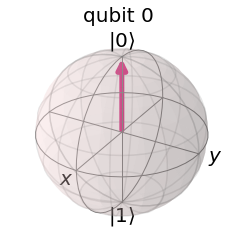

In [18]:
backend_statevector = BasicAer.get_backend('statevector_simulator')
circuit = QuantumCircuit(q, c)
circuit.id(q[0])
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

Comparandolo con la recta que teníamos en el cuadrante positivo para probabilidades compleas, vemos que estamos ante un escnario mucho más rico.

Veamos otro punto en la esfera de Bloch. Transfomemos $|0\rangle$ a $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Esto se corresponde con una moneda de distribución uniforme (obtenemos 0 con probabilidad $|\frac{1}{\sqrt{2}}|^2=1/2$). Hay muchas formas de transformar a este estado, una es por ejemplo rotar alrededor del eje Y en $\pi/2$, que se corresponde con la matriz $\frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -1\\1 & 1\end{bmatrix}$.

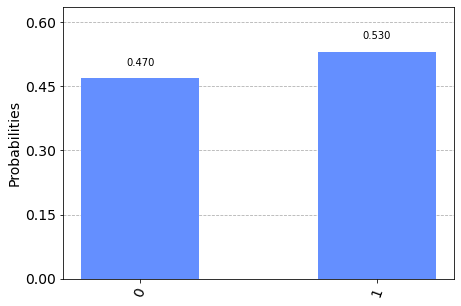

In [19]:
circuit = QuantumCircuit(q, c)
circuit.ry(π/2, q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

Para ganar intuición respecto a la rotación veamos como queda en la esfera de Bloch:

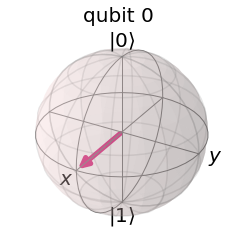

In [20]:
circuit = QuantumCircuit(q, c)
circuit.ry(π/2, q[0])
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

¿Por que es interesante tener amplitudes de probabilidades complejas en lugar de números positivos reales? Veamos que pasa si aplicamos esta misma rotación al estado $|1\rangle$. Para esto invertimos primero el estado $|0\rangle$  aplicando la compuerta NOT (se corresponde con $\sigma_x$, la [matriz de Pauli](https://en.wikipedia.org/wiki/Pauli_matrices) en x en computación cuántica, y se denota con X en qiskit)

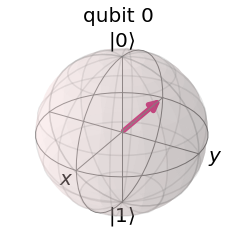

In [21]:
circuit = QuantumCircuit(q, c)
circuit.x(q[0])
circuit.ry(π/2, q[0])
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

Esto nos lleva a $\frac{1}{\sqrt{2}}(-|0\rangle + |1\rangle)$. Es el mismo estado de antes, pero con un cambio de signo (fase) en el primer elemento. Esta diferencia no puede ser detectada por la estadística:

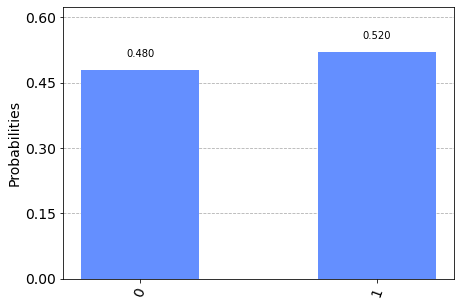

In [22]:
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

Sigue pareciendo una moneda homogénea. Sin embargo, ese cambio de signo (o cualquier valor complejo), es crucial para modelar interferencia, que es un fenómeno super importante en el cual las aplitudes de probabilidad pueden interactuar de forma destructiva o constructiva. Si aplicamos la rotación 2 veces consecutivas al estado $|0\rangle$ obtenemos el estado $|1\rangle$.

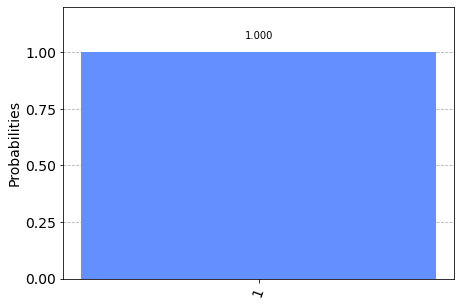

In [23]:
circuit = QuantumCircuit(q, c)
circuit.ry(π/2, q[0])
circuit.ry(π/2, q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

Muchos algoritmos cuánticos aprovechan interferencia, como por ejemplo el algoritmo de  [Deutsch-Josza](https://en.wikipedia.org/wiki/Deutsch–Jozsa_algorithm) (uno de los primeros en llamar la atención).

### Notación: Bra

Antes de seguir adentrandonos, es necesario introducir una notación adicional, que es la de los "bra": se denotan  $\langle\psi|$ para un estado $|\psi\rangle$. El "bra" es el conjugado transpuesto del "ket" y viceversa, es decir, es un vector fila. Por ejemplo este es el  bra para $|0\rangle$

In [24]:
import numpy as np
zero_ket = np.array([[1], [0]])
print("|0> ket:\n", zero_ket)
print("<0| bra:\n", zero_ket.T.conj())

|0> ket:
 [[1]
 [0]]
<0| bra:
 [[1 0]]


Los productos internos entre bras y kets son sumamente sencillos: Un bra por un ket. Es tan común de usar, que solemos no poner una de las lineas verticales entre medio y escribimos $\langle 0|0\rangle$. Como los estados están normalizados, el producto interno entre dos estados cuánticos  iguales es siempre 1:

In [25]:
zero_ket.T.conj() @ zero_ket

array([[1]])

Y entre estados ortogonales, obtenemos 0:

In [26]:
one_ket = np.array([[0], [1]])
zero_ket.T.conj() @ one_ket

array([[0]])

¿Y si hacemos ket por bra? Esto va a ser una matriz

In [27]:
zero_ket @ zero_ket.T.conj()

array([[1, 0],
       [0, 0]])

Este resultado no es otra cosa que el proyector al subespacio al primer elemento de la base canónica. En general, $|\psi\rangle\langle\psi|$ es el proyector a $|\psi\rangle$. Dado otro estado  $|\phi\rangle$, si le aplicamos esta proyección tenemos $|\psi\rangle\langle\psi|\phi\rangle$. A la derecha nos queda un producto interno, que es el overlap entre  $|\phi\rangle$ y $|\psi\rangle$. Con lo cual terminamos con un estado paralelo a la dirección de proyección con  el overlap como módulo.

Este proyector se conoce también como matriz densidad y esconde propiedades sumamente interesantes.

# Más qubits y entrelazamiento



Ya vimos que los estados cuánticos son distribuciones de probabilidad normalizados a 1 en norma $l_2$, y ganamos algo de intuición sobre interferencia. ¿Que pasa si ahora agregamos más qubits? Vamos a ver emerger otro efecto cuántico maravilloso.

Comencemos por escribir un estado de 2 qubits. Para eso usamos un producto tensorial, que en el caso de qubits, es equivalente a un producto de Kroenecker. Dados 2 qubits, $|\psi\rangle=\begin{bmatrix}a_0\\a_1\end{bmatrix}$ y $|\psi'\rangle=\begin{bmatrix}b_0\\b_1\end{bmatrix}$, el producto tensorial es $|\psi\rangle\otimes|\psi'\rangle=\begin{bmatrix}a_0b_0\\ a_0b_1\\ a_1b_0\\ a_1b_1\end{bmatrix}$. Si tenemos dos registros $q_0$ y $q_1$, cada uno con un qubit, ambos inicializados en  $|0\rangle$. Obtenemos el estado resultante de la siguiente manera:

In [28]:
q0 = np.array([[1], [0]])
q1 = np.array([[1], [0]])
np.kron(q0, q1)

array([[1],
       [0],
       [0],
       [0]])

Este es el estado $|0\rangle\otimes|0\rangle$, que abreviamos como $|00\rangle$. Los estados $|01\rangle$, $|10\rangle$ y $|11\rangle$ se definen de forma análoga. Todos ellos forman una base canónica en el espacio 4-dimensional complejo,  $\mathbb{C}^2\otimes\mathbb{C}^2$.

Ahora es donde viene lo interesante y contraintuitivo. En Machine Learning trabajamos también con espacio de alta dimensionalidad, pero nunca los construimos con productos tensoriales: tipicamente tenemos $\mathbb{R}^d$ para alguna dimensión $d$. Lo interesante de escribir el espacio de alta dimensionalidad como un producto tensorial es que no todos los vectores en $\mathbb{C}^2\otimes\mathbb{C}^2$ pueden ser escritos como un producto de vectores.

A modo de ejemplo, tomemos el estado $|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$. Este vector está claramente en $\mathbb{C}^2\otimes\mathbb{C}^2$, ya que es la combinación lineal de dos de los vectores de la base en este espacio. Sin embargo no puede obtenerse como  $|\psi\rangle\otimes|\psi'\rangle$ para ningunos $|\psi\rangle$, $|\psi'\rangle\in\mathbb{C}^2$.

Veamoslo por absurdo. Supongamos que efectivamente fuese posible. Entonces tendríamos

$$
|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) = \begin{bmatrix}a_0b_0\\ a_0b_1\\ a_1b_0\\ a_1b_1\end{bmatrix} = a_0b_0|00\rangle + a_0b_1|01\rangle + a_1b_0|10\rangle + a_1b_1|11\rangle.
$$

con $a_0,b_0,a_1,b_1 \in \mathbb{C}$. Vemos que $|01\rangle$ y $|10\rangle$ no aparecen del lado izquierdo, con lo cual sus coeficientes deben ser nulos: $a_1b_0=0$ y $a_0b_1=0$. Esto lleva a una contradicción, ya que  $a_1$ no puede ser cero ($a_1b_1=1$), entonces  $b_0$ debe ser cero, pero $a_0b_0=1$. Luego $|\phi^+\rangle$ no puede escribirse como un producto de estados.

Los estados que no pueden escribirse como un producto, se conocen como [estados entrelazados](https://en.wikipedia.org/wiki/Quantum_entanglement). Esta es la forma matemática de descrbibir un fenómeno de correlación fuerte entre variables aleatorias, que de hecho excede lo que es [clasicamente posible](https://en.wikipedia.org/wiki/Bell%27s_theorem). El entrelazamiento juega un rol crucial en muchos algoritmos cuánticos, como por ejemplo  [teleportación cuántica](https://en.wikipedia.org/wiki/Quantum_teleportation). Vamos a ver también que tiene aplicaciones importantes en quantum machine learning.

Veamos la estadística obtenida de medir sobre el estado $|\phi^+\rangle$.  Para llegar a este estado usamos dos compuertas que van a ser claves y vamos a ver en el notebook de computación cuántica del tipo Gate-Model: Hadamard y CNOT

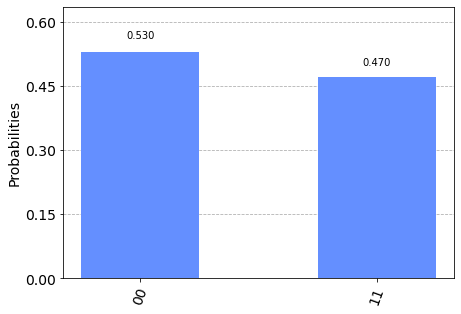

In [29]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

Vemos que 01 y 10 no aparecen en la estadística.

# Medidas

La medida es un concepto central en mecánica cuántica. La medida arroja un resultado que se obtiene con cierta probabilidad determinada por el estado.

Las medidas conectan el mundo cuántico con el clásico: no podemos observar directamente el mundo cuántico, lo que hacemos es juntar estadística obtenida de las medidas. Dicho de esta forma, parecería ser que hay una frontera rígida entre ambos mundos, sin embargo esto no es exactamente así. A no ser que un sistema cuántico esté perfectamente aislado, este interactúa con su ambiente. Esto conduce a la introducción de estados mixtos, que se tienden a distribuciones de probabilidad clásicas en cierto límite.

Matemáticamente, una medida es un operador que se aplica sobre los estados y devuelve una variable aleatoria. Las medidas son operaciones extremadamente complejas, sin embargo en computación cuántica se usan operaciones relativamente simples. Estas son medidas proyectivas en la base canónica, es decir se proyecta a $|0\rangle\langle 0|$ y $|1\rangle\langle 1|$. Ya vimos como operan las proyecciones. Si queremos convertir esto en un escalar, le agregamos un bra a la izquierda. Por ejemplo, para el estado  $|\psi\rangle$, obtenemos un escalar para $\langle\psi|0\rangle\langle 0|\psi\rangle$ (valor de expectación del operador $|0\rangle\langle 0|$). Apliquemos la proyección $|0\rangle\langle 0|$ en la superposición $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, que es el vector columna $\frac{1}{\sqrt{2}}\begin{bmatrix} 1\\ 0\end{bmatrix}$.


In [30]:
zero_ket = np.array([[1], [0]])
ψ = np.array([[1], [0]])/np.sqrt(2)
Π_0 = zero_ket @ zero_ket.T.conj()
ψ.T.conj() @ Π_0 @ ψ

array([[0.5]])

Dado un estado  $|\psi\rangle = a_0|0\rangle + a_1|1\rangle$, obtenemos el resultado $i$ con probabilidad $|a_i|^2$ (regla de Born). Extraemos las probabilidades con medidas. Creemos una superposición usando la compuerta de Hadamard (explicada en el notebook de gate model) y veamos la estadística:


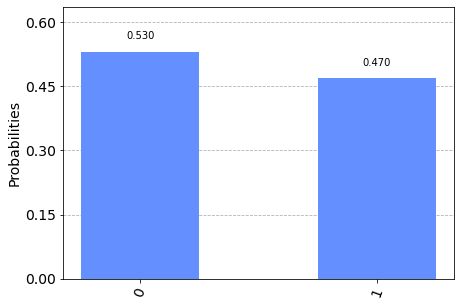

In [31]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

El resultado es aleatorio con probabilidades cercanas a 1/2. Cada vez que se aplica la medida, la superposición se destruye. Esto se conoce como colapso de la función de onda. Es objeto de muchos debates e investigaciones, pero lo que nos interesa a nosotros es que podemos calcular fácilmente el estado después de la medida. Lo que es importante entender es que gracias a esta propiedad la física no es determinista. Es decir, es imposible a partir de condiciones iniciales, saber como será el futuro, ya que en el medio tenemos medidas con resultados aleatorios (esto generó mucha controversia con Einstein).

Después de proyectar con la medida, es necesario normalizar para tener un estado cuántico. Esto se escribe matemáticamente como $\frac{|i\rangle\langle i|\psi\rangle}{\sqrt{\langle\psi|i\rangle\langle i|\psi\rangle}}$, si observamos como resultado $i$. Por ejemplo, si observamos 0 después de medir la superposición $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, el estado después de medir será

In [32]:
ψ = np.array([[np.sqrt(2)/2], [np.sqrt(2)/2]])
Π_0 = zero_ket @ zero_ket.T.conj()
probability_0 = ψ.T.conj() @ Π_0 @ ψ
Π_0 @ ψ/np.sqrt(probability_0)

array([[1.],
       [0.]])

Que es el $|0\rangle$.

Esto se ve claramente si ponemos 2 medidas una después de la otra sobre el mismo qubit. La segunda dará siempre el mismo output que la primero. La primera es aleatoria, pero la segunda está determinada, ya que no hay más superposición luego de la primer medida. Simulemoslo poniendo los resultados en 2 registros clásicos distintos:

In [33]:
backend = Aer.get_backend('qasm_simulator')
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q[0], c[0])
circuit.measure(q[0], c[1])
job = execute(circuit, backend, shots=100)
job.result().get_counts(circuit)

{'00': 53, '11': 47}

### Medidas en sistemas de muchas partículas

La gran mayoría de las compus cuánticas usan medidas locales, es decir que cada qubit se mide separadamente. Si tenemos un sistema de 2 qubits, donde el primer qubit se encuentra en superposición homogenea y el segundo en $|0\rangle$, es decir tenemos el estado $\frac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$, observamos (0, 0) ó (0, 1) como resultados.

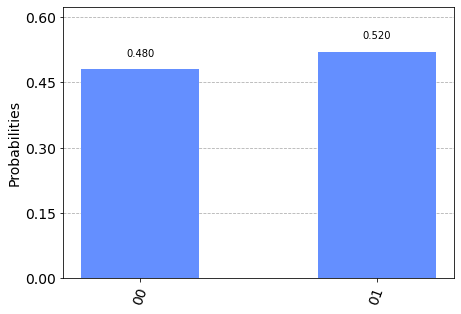

In [34]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

En un estado entrelazado, como  $|\phi^+\rangle$:

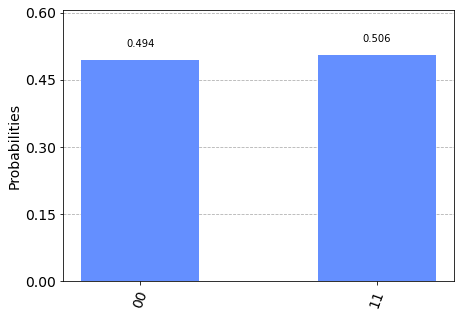

In [35]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
job = execute(circuit, backend, shots=10000)
plot_histogram(job.result().get_counts(circuit))

Vemos solo 00 y 11. Como el estado es  $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$, esto no debería ser una sorpresa. Sin embargo hay algo llamativo. Vimos ya estados como mezclas homogeneas al medir sobre el mismo qubit. Acá tenemos, sin embargo, las mismas estadísticas pero midiendo en qubits separados espacialmente. Esta es una forma fuerte de correlación. Si medimos solo 1 qubit y obetenemos 0, sabemos con certeza que si medimos el otro, obtendremos también 0, a pesar de tratarse la segunda medida de una variable aleatoria.

Para comprender mejor lo extraño de esto, basta imaginar un ejemplo en el cual arrojamos 2 monedas sin bias ( iguales probabilidades). Si observamos cara en una, no hay nada que podamos decir sobre la otra, más que adivinar que tiene un resultado con 0.5 de probabilidad. Nunca podemos decir con certeza que la otra moneda vaya a tener el mismo resultado que la primera, a no ser que estemos en el caso trivial donde se determinan deterministicamente (monedas pegadas por ejemplo). Sin embargo con qubits podemos afirmar este tipo de cosas.

No hay ninguna activación instantanea entre los qubits. La medida fue local en el qubit. Es simplemente una forma fuerte de correlación, que resulta más fuerte que lo conseguible clásicamente y juega un rol central en muchos algoritmos cuánticos. Juega un rol de recurso, que se consume al ejecutar algoritmos (de forma similar a como se consume petroleo para mover una máquina). El petroleo de nuestros algoritmos es la correlación cuántica.

# Estados mixtos

Un ket y un bra forman una proyección, como ya vimos. Pero además de eso, son también una matriz densidad. Esta es otra forma de escribir un estado cuántico. En lugar de escribir el estado $|\psi\rangle$, podemos escribir  $\rho = |\psi\rangle\langle\psi|$, donde $\rho$ es la matriz densidad. Aplica la regla de Born, pero tenemos que tomar la traza del resultado. Por ejemplo  $\mathrm{Tr}[|0\rangle\langle 0|\rho]$ será la probabilidad de ver 0.

In [36]:
ψ = np.array([[1], [1]])/np.sqrt(2)
ρ = ψ @ ψ.T.conj()
Π_0 = zero_ket @ zero_ket.T.conj()
np.trace(Π_0 @ ρ)

0.4999999999999999

La renormalización después de medir es ahora: $\frac{|0\rangle\langle 0|\rho|0\rangle\langle 0|}{\mathrm{Tr}[|0\rangle\langle 0|\rho]}$.

In [37]:
probability_0 = np.trace(Π_0 @ ρ)
Π_0 @ ρ @ Π_0/probability_0

array([[1., 0.],
       [0., 0.]])

¿Pero para que sirve esto, si ya tenemos toda la estadística con el estado? Todos los estados que vimos hasta ahora son *estados puros*: estos pueden escribirse como kets, o como el producto de 1 solo ket por bra. Sin embargo hay otro tipo de estados más generales que se llaman *estados mixtos*: estos son distribuciones de probabilidad *clásicas* sobre estados puros. Formalmente, un estado mixto se escribe como $\sum_i p_i |\psi_i\rangle\langle\psi_i|$, donde $\sum_i p_i=1$, $p_i\geq 0$. Es decir, tenemos combinaciones estadísticas de estados puros. Hay una ignorancia *clásica* sobre el estado cuántico subyaciente. Comparemos la matriz densidad de la superposición homogenea  $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ y el estado mixto $0.5(|0\rangle\langle 0|+|1\rangle\langle 1|)$:

In [38]:
zero_ket = np.array([[1], [0]])
one_ket = np.array([[0], [1]])
ψ = (zero_ket + one_ket)/np.sqrt(2)
print("Matriz densidad de superposición homogenea")
print(ψ @ ψ.T.conj())
print("Matriz densidad de estado mmixto homogeneo mezcla entre |0><0| y |1><1|")
print((zero_ket @ zero_ket.T.conj()+one_ket @ one_ket.T.conj())/2)

Matriz densidad de superposición homogenea
[[0.5 0.5]
 [0.5 0.5]]
Matriz densidad de estado mmixto homogeneo mezcla entre |0><0| y |1><1|
[[0.5 0. ]
 [0.  0.5]]


En el segundo caso, no hay elementos fuera de la diagonal. Estos elementos se llaman coherencias: su presencia indica que los estados son "cuánticos". Cuanto más pequeños sean estos elementos, más cerca está el estado cuántico de distribuciones de probabilidad clásicas.

La segunda matriz desidad tiene solo elementos diagonales iguales: esto es quivalente a escribir la distribución uniforma. Sabemos que la distribución uniforme maximiza la entropía, y por este motivo lo llamamos máximamente mixto. Tenemos ignorancia perfecta de que elemento de la base canónica constituye al estado.

Nos encantaría que los estados cuánticos estén perfectamente aislados del ambiente, pero en realidad las computadores cuánticas disponibles no consiguen un grado alto de aislamiento. Esto hace que las coherencias se pierdan lentamente en el entorno. Este fenómeno se conoce como decoherencia. La velocidad a la que esto pasa determina el tiempo de los algoritmos cuánticos que podemos correr en las computadoras cuánticas: si pasa muy rápidamente, tenemos tiempo de aplicar unas pocas compuertas y debemos extraer rápidamente los resultados.
